In [16]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error
# WHEN CHECKING THE MODEL: use as np.sqrt(mean_squared_log_error( y_test, predictions ))
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline

---
# Load the Data

### Building and Weather Data

In [2]:
# Note: These assume that the data has been saved to a subdirectory named "energy"
bldgData = pd.read_csv("energy/building_metadata.csv")
weatherTrain = pd.read_csv("energy/weather_train.csv")
weatherTest = pd.read_csv("energy/weather_test.csv")
allWeather = weatherTrain.append(weatherTest)

I'm combining the weather data into one dataframe. There's really no need for it to be separate. Plus, I have a hunch that the _current_ meter reading is better modeled as a function of the average of the _current_ weather data and the _last_ weather data. In other words, how much energy a building used in the last hour is based on the weather for the last hour, not necessarily the weather at the current timestamp. If this is the case, then the first prediction in the test data will need the last weather data from the training set.

### Training Data

In [3]:
energyTrain = pd.read_csv("energy/train.csv")

### Test Data
Warning: This will use a lot of memory! My virtual machine is sitting at 5.5 GB of RAM utilization right now.

In [4]:
energyTest = pd.read_csv("energy/test.csv")

### Explore the Data

In [7]:
print(energyTest.shape)
print(energyTrain.shape)

(41697600, 4)
(20216100, 4)


In [5]:
trainJoinBldg = pd.merge(energyTrain, bldgData, on='building_id')
fullTraining = pd.merge(trainJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [89]:
# Explore new dataframes
print(energyTrain.shape)
print(trainJoinBldg.shape)
thrownOut = energyTrain.shape[0] - trainJoinBldg.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ energyTrain.shape[0]
print("% thrown out by merging with building data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
print(fullTraining.shape)
thrownOut = trainJoinBldg.shape[0] - fullTraining.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ trainJoinBldg.shape[0]
print("% thrown out by merging with weather data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
#print(trainJoinBldg.head(5))
#print(fullTraining.head(5))
print(fullTraining.columns)

(20216100, 4)
(20216100, 9)
% thrown out by merging with building data: 0.00%
(20216100, 16)
% thrown out by merging with weather data: 0.00%
Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')


`fullTraining` now has all the provided training data merged into one dataframe. i.e. Each row contains the meter reading, building info, and weather for that site+timestamp all in one row.

Only 0.45% of the rows get lost when merging with the weather data. This implies that not every site+timestamp is present in the weather data.

I assume it will also be necessary to repeat these steps for the test data prior to making predictions; however, if weather data is not present for a given site+timestamp, we cannot just drop the row - we must still make a prediction.

# Linear Regression Separate Models

In [5]:
trainJoinBldg = pd.merge(energyTrain, bldgData, on='building_id')
fullTraining = pd.merge(trainJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [6]:
fullTraining4 = fullTraining
fullTraining4["timestamp"] = pd.to_datetime(fullTraining4["timestamp"])

In [7]:
#this takes a while (around 3 minutes)
fullTraining4['workday'] = [1 if x.weekday() > 4 else 0 for x in fullTraining4['timestamp']]

In [8]:
sr = fullTraining4['timestamp']
fullTraining4['hour'] = sr.dt.hour

In [14]:
fullTraining4Dummies = pd.get_dummies(fullTraining4, columns=['meter', 'primary_use', 'site_id'], drop_first=True)

In [15]:
print(fullTraining4Dummies.columns)

Index(['building_id', 'timestamp', 'meter_reading', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'workday', 'hour', 'meter_1', 'meter_2',
       'meter_3', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'site_id_1', 'site_id_2', 'site_id_3',
       'site_id_4', 'site_id_5', 'site_id_6', 'site_id_7', 'site_id_8',
       'site_id_9', 'site_id_10', 'site_id_11', 'site_id_12', 'site_id_13',


In [17]:
airTempMean = fullTraining4Dummies['air_temperature'].mean()
fullTraining4Dummies['air_temperature'] - airTempMean
fullTraining4Dummies['air_temperature'] = fullTraining4Dummies['air_temperature'].abs()
fullTraining4Dummies['year_built'] = 2019 - fullTraining4Dummies['year_built']

In [62]:
#Splitting into features and labels
X = fullTraining4Dummies[['year_built', 'air_temperature', 'hour']].values
y = fullTraining4Dummies['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

In [63]:
print(X.shape)
print(y.shape)

(20216100, 3)
(20216100,)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [65]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [66]:
coeff_df = pd.DataFrame(regressor.coef_, [['year_built', 'air_temperature', 'hour']], columns=['Coefficient'])  
#coeff_df = pd.DataFrame(regressor.coef_, [['air_temperature', 'dew_temperature']], columns=['Coefficient'])  
coeff_df

,Coefficient
year_built,-41.512773
air_temperature,-81.087282
hour,27.859458


In [67]:
y_pred = regressor.predict(X_test)

In [68]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

,Actual,Predicted
0,109.0000,3638.436740
1,17.4250,3386.252701
2,4.1231,362.731120
3,1089.8000,3826.386401
4,82.9440,521.471689
5,65.4333,3386.252701
6,6.0000,2327.313857
7,8.7921,1174.399304
8,185.0000,2720.294804
9,0.3332,4389.421924


In [69]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3870.378413082835
Mean Squared Error: 23906519297.11692
Root Mean Squared Error: 154617.33181347078


## New Approach

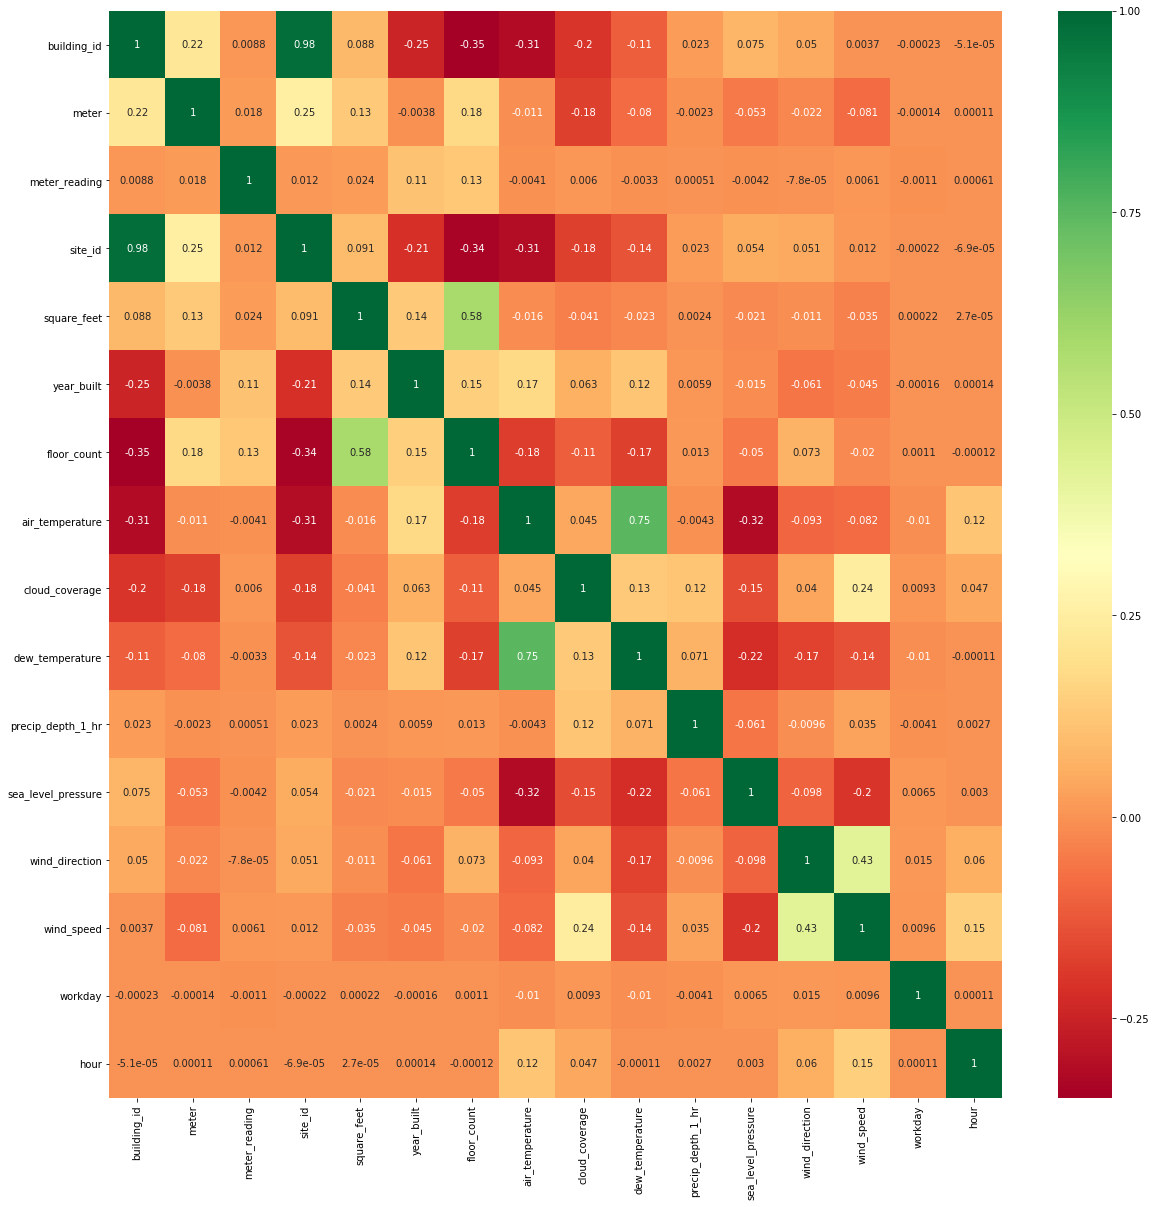

In [19]:
corrmat = fullTraining4.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=seabornInstance.heatmap(fullTraining4[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [35]:
uses = fullTraining4['primary_use'].unique().tolist()
usage_models = {}

for use in uses:
    usage_models[use + "_model"] = fullTraining4.loc[fullTraining4.primary_use == use]

In [36]:
m = usage_models['Education_model']
m[m['meter_reading'] == 0]['meter'].unique().tolist()

[0, 1, 3, 2]

In [38]:
sites = fullTraining4['site_id'].unique().tolist()
site_usage_models = {}
for model in usage_models:
    currModel = usage_models[model]
    for site in sites:
        site_usage_models["site" + str(site) + "_" + model] = currModel.loc[currModel.site_id == site]

In [39]:
meters = fullTraining4['meter'].unique().tolist()
usage_meters_models = {}
for model in site_usage_models:
    currModel = site_usage_models[model]
    for meter in meters:
        usage_meters_models["meter" + str(meter) + "_" + model] = currModel.loc[currModel.meter == meter]

In [44]:
usage_meters_site_workday_models = {}
for model in usage_meters_models:
    usage_meters_site_workday_models["workday_" + model] = usage_meters_models[model].loc[usage_meters_models[model].workday == 0]
    usage_meters_site_workday_models["nonworkday_" + model] = usage_meters_models[model].loc[usage_meters_models[model].workday == 1]

In [ ]:
regressors = {}
for model in usage_meters_site_workday_models:
    regressors[model] = LinearRegression()
    regressors[model].fit(X_train, y_train)
    for meter in meters:
        usage_meters_models["meter" + str(meter) + "_" + model] = currModel.loc[currModel.meter == meter]

# Incomplete -- found better approach (decisionTree)